In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.append('utils/')

import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# use non standard flow_from_directory
from image_preprocessing_ver2 import ImageDataGenerator
# it outputs y_batch that contains onehot targets and logits
# logits came from xception

from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K

from squeezenet import SqueezeNet, preprocess_input

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
data_dir = '/home/ubuntu/data/'

In [4]:
train_logits = np.load(data_dir + 'train_logits.npy')[()]
val_logits = np.load(data_dir + 'val_logits.npy')[()]

In [5]:
data_generator = ImageDataGenerator(
    data_format='channels_last',
    preprocessing_function=preprocess_input
)

# note: i'm also passing dicts of logits
train_generator = data_generator.flow_from_directory(
    data_dir + 'train', train_logits,
    target_size=(299, 299),
    batch_size=64
)

val_generator = data_generator.flow_from_directory(
    data_dir + 'val', val_logits,
    target_size=(299, 299),
    batch_size=128
)

Found 25600 images belonging to 256 classes.
Found 5120 images belonging to 256 classes.


# Show effect of temperature

In [6]:
def softmax(x):
    return np.exp(x)/np.exp(x).sum()

In [7]:
# get a random batch
pictures, labels_and_logits = train_generator.next()
onehot_target, logits = labels_and_logits[:, :256], labels_and_logits[:, 256:]

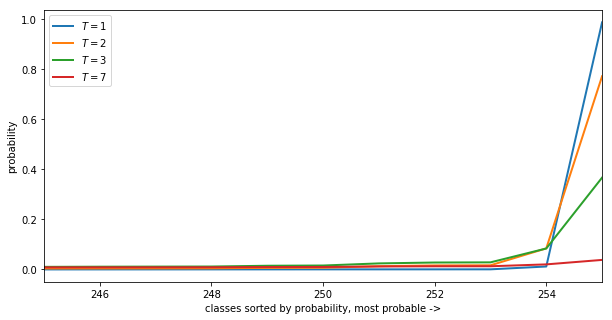

In [9]:
# logits for a random image
v = logits[0]
plt.figure(figsize=(10, 5));
plt.plot(np.sort(softmax(v)), label='$T=1$', linewidth=2);
plt.plot(np.sort(softmax(v/2)), label='$T=2$', linewidth=2);
plt.plot(np.sort(softmax(v/3)), label='$T=3$', linewidth=2);
plt.plot(np.sort(softmax(v/7)), label='$T=7$', linewidth=2);
plt.legend();
plt.xlabel('classes sorted by probability, most probable ->');
plt.ylabel('probability');
plt.xlim([245, 255]);

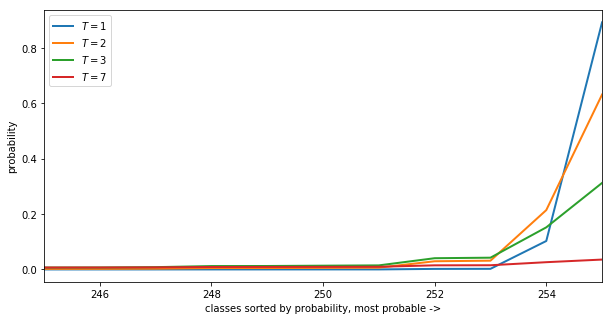

In [14]:
# logits for a random image
v = logits[14]
plt.figure(figsize=(10, 5));
plt.plot(np.sort(softmax(v)), label='$T=1$', linewidth=2);
plt.plot(np.sort(softmax(v/2)), label='$T=2$', linewidth=2);
plt.plot(np.sort(softmax(v/3)), label='$T=3$', linewidth=2);
plt.plot(np.sort(softmax(v/7)), label='$T=7$', linewidth=2);
plt.legend();
plt.xlabel('classes sorted by probability, most probable ->');
plt.ylabel('probability');
plt.xlim([245, 255]);

# Create model

In [15]:
temperature = 5.0

In [16]:
model = SqueezeNet(weight_decay=1e-5, image_size=299)

# remove softmax
model.layers.pop()

# usual probabilities
logits = model.layers[-1].output
probabilities = Activation('softmax')(logits)

# softed probabilities
logits_T = Lambda(lambda x: x/temperature)(logits)
probabilities_T = Activation('softmax')(logits_T)

output = concatenate([probabilities, probabilities_T])
model = Model(model.input, output)
# now model outputs 512 dimensional vectors

# Create custom loss

In [17]:
def knowledge_distillation_loss(y_true, y_pred, lambda_const):    
    
    # split in 
    #    onehot hard true targets
    #    logits from xception
    y_true, logits = y_true[:, :256], y_true[:, 256:]
    
    # convert logits to soft targets
    y_soft = K.softmax(logits/temperature)
    
    # split in 
    #    usual output probabilities
    #    probabilities made softer with temperature
    y_pred, y_pred_soft = y_pred[:, :256], y_pred[:, 256:]    
    
    return lambda_const*logloss(y_true, y_pred) + logloss(y_soft, y_pred_soft)

# For testing use usual output probabilities (without temperature)

In [18]:
def accuracy(y_true, y_pred):
    y_true = y_true[:, :256]
    y_pred = y_pred[:, :256]
    return categorical_accuracy(y_true, y_pred)

In [19]:
def top_5_accuracy(y_true, y_pred):
    y_true = y_true[:, :256]
    y_pred = y_pred[:, :256]
    return top_k_categorical_accuracy(y_true, y_pred)

In [20]:
# logloss with only soft probabilities and targets
def soft_logloss(y_true, y_pred):     
    logits = y_true[:, 256:]
    y_soft = K.softmax(logits/temperature)
    y_pred_soft = y_pred[:, 256:]    
    return logloss(y_soft, y_pred_soft)

# Train

In [21]:
lambda_const = 0.2

model.compile(
    optimizer=optimizers.SGD(lr=1e-2, momentum=0.9, nesterov=True), 
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, lambda_const), 
    metrics=[accuracy, top_5_accuracy, soft_logloss]
)

In [22]:
model.fit_generator(
    train_generator, 
    steps_per_epoch=400, epochs=30, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.01),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, epsilon=0.007)
    ],
    validation_data=val_generator, validation_steps=40, workers=4
)

Epoch 1/30
400/400 [==============================] - 31s - loss: 6.0780 - accuracy: 0.4021 - top_5_accuracy: 0.6189 - soft_logloss: 5.4767 - val_loss: 5.8090 - val_accuracy: 0.5811 - val_top_5_accuracy: 0.8209 - val_soft_logloss: 5.4503
Epoch 2/30
400/400 [==============================] - 30s - loss: 5.7476 - accuracy: 0.6618 - top_5_accuracy: 0.8571 - soft_logloss: 5.4402 - val_loss: 5.7558 - val_accuracy: 0.6227 - val_top_5_accuracy: 0.8482 - val_soft_logloss: 5.4472
Epoch 3/30
400/400 [==============================] - 30s - loss: 5.6767 - accuracy: 0.7321 - top_5_accuracy: 0.9016 - soft_logloss: 5.4343 - val_loss: 5.7260 - val_accuracy: 0.6697 - val_top_5_accuracy: 0.8664 - val_soft_logloss: 5.4467
Epoch 4/30
400/400 [==============================] - 30s - loss: 5.6390 - accuracy: 0.7748 - top_5_accuracy: 0.9251 - soft_logloss: 5.4316 - val_loss: 5.7286 - val_accuracy: 0.6508 - val_top_5_accuracy: 0.8611 - val_soft_logloss: 5.4445
Epoch 5/30
400/400 [============================

# Results

In [23]:
val_generator_no_shuffle = data_generator.flow_from_directory(
    data_dir + 'val', val_logits,
    target_size=(299, 299),
    batch_size=64, shuffle=False
)

Found 5120 images belonging to 256 classes.


In [24]:
print(model.evaluate_generator(val_generator_no_shuffle, 80))

[5.7060729444026945, 0.68300781249999998, 0.87539062499999998, 5.4443621456623079]
